# Word Level Federated Text Generation with Stack Overflow with Randomly Initialized or Pretrained Word Embeddings
- Joel Stremmel
- 02-24-20
- Runs on GCP and local Ubuntu 16.04

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer is initialized with one of the following options by setting the `EMBEDDING_LAYER` parameter:
- [GloVe](https://nlp.stanford.edu/projects/glove/) ([license here](https://www.opendatacommons.org/licenses/pddl/1.0/))
- [FastText](https://fasttext.cc/docs/en/english-vectors.html) ([license here](https://creativecommons.org/licenses/by-sa/3.0/))
- [GPT-2](https://openai.com/blog/better-language-models/) ([license here](https://github.com/huggingface/transformers/blob/master/LICENSE))
- [Randomly initialized embeddings](https://www.tensorflow.org/api_docs/python/tf/random_uniform_initializer)  

After downloading the GloVe or FastText embeddings, place the embedding files at the top level of the repository in directories called `word_embedding/glove` and `word_embedding/fasttext` respectively.  GPT-2 embeddings are downloaded by running the notebook which makes a call to `src/embeddings.py` to download the embeddings from [huggingface](https://github.com/huggingface/transformers).  

**Code from Tensorflow Federated:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data and Model References:**
- [TFF Stack Overflow `load_data`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data)
- [TFF text generation tutorial](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb)
- [Google TFF team research baselines for Stack Overflow](https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow)
- [Tensorflow text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

**Environment Setup References:**
- [Installing Tensorflow for GPU](https://www.tensorflow.org/install/gpu)
- [Install CUDA 10.0 and cuDNN v7.4.2 on Ubuntu 16.04](https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d)
- [Tensorflow build configs](https://www.tensorflow.org/install/source#tested_build_configurations)
- [Using jupyter notebooks with a virtual environment](https://anbasile.github.io/programming/2017/06/25/jupyter-venv/)

### Imports

In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [4]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

### Set Some Parameters for Preprocessing the Data and Training the Model

In [5]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 20000
NUM_TEST_EXAMPLES = 100

NUM_ROUNDS = 800
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 300
RNN_UNITS = 512

EMBEDDING_LAYER = 'pp_pca_pp_gpt2'
SAV = 'embedding_layer_results/pretrainedNet_{}_{}_{}_{}/'.format(EMBEDDING_LAYER, 
                                                    EMBEDDING_DIM, 
                                                    RNN_UNITS, 
                                                    EMBEDDING_DIM)

### Create the Output Directory if it Nonexistent

In [6]:
if not os.path.exists(SAV):
    os.makedirs(SAV)

### Load and Preprocess Word Level Datasets

In [7]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

A local file was found, but it seems to be incomplete or outdated because the sha256 file hash does not match the original value of 99eca2f8b8327a09e5fc123979df2d237acbc5e52322f6d86bf523ee47b961a2 so we will re-download the data.
9076670464/9076663578 [==============================] - 505s 0us/step


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


97239040/97235487 [==============================] - 5s 0us/step


### Retrieve the Dataset Vocab

In [8]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Set Extended Vocab Size
We account for the following four special tokens applied during preprocessing with `construct_word_level_datasets`:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [9]:
extended_vocab_size = VOCAB_SIZE + len(dataset.get_special_tokens(VOCAB_SIZE))

## Beginning of central pre-training based on Shakespeare

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [10]:
pad, oov, bos, eos = dataset.get_special_tokens(VOCAB_SIZE)

In [11]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

## Now we try to use a different text corpus for pre-training. The Shakespeare Text Dataset is used.

#### The vocab for pre-training is now different from that of fine-tuning, so that must be handled first.

#### Also, the major benefits of doing this in the same notebook as the previous pre-training/fine-tuning approach is to save time of accessing the TFF SO dataset and also to make a comparison of all the training processes together.

In [5]:
## Using a different data set (such as Shakespeare, and later Wikipedia) to do the central Pre-Training using TensorFlow
with open('../../raw_shakespeare_data.txt') as f:
    # This reads all the data from the file, but does not do any processing on it.
    data = f.read()

In [14]:
# preprocessing to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
data = " ".join(data.split())

In [15]:
data[:100]

'The Project Gutenberg EBook of The Complete Works of William Shakespeare, by William Shakespeare Thi'

In [16]:
len(data.split())

904065

In [17]:
VOCAB_SIZE

10000

In [18]:
word_counts_sp = collections.OrderedDict()
for word in data.split():
    word_counts_sp[word] = word_counts_sp.get(word, 0) + 1

In [19]:
vocab_sp = list(word_counts_sp.keys())[:VOCAB_SIZE]

In [20]:
len(vocab_sp)

10000

### Set Vocabulary for Shakespeare Dataset
Add one to account for the pad token which has idx 0.

In [21]:
word2idx_sp = {word:i+1 for i, word in enumerate(vocab_sp)}
idx2word_sp = {i+1:word for i, word in enumerate(vocab_sp)}

In [22]:
len(word2idx_sp)

10000

### Add Special Characters

In [23]:
word2idx_sp = {**word2idx_sp, **special2idx}
idx2word_sp = {**idx2word_sp, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [25]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

In [27]:
encoded = []
for word in data.split():
    if not word2idx_sp.get(word,0):
        encoded.append(oov)
    else:
        encoded.append(word2idx_sp[word])

In [30]:
X = list()
Y = list()
for i in range(len(encoded)-1):
    X.append(encoded[i])
    Y.append(encoded[i + 1])

In [35]:
X = np.expand_dims(X, 1)
Y = np.expand_dims(Y, 1)

### Next is the attempted pre-training using the Shakespeare corpus

### Load or Build the Model and Try Generating Some Text

In [39]:
keras_model_sp = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix='uniform',
                                rnn_units=RNN_UNITS)

In [40]:
evaluation_metrics_sp = validation.get_metrics(VOCAB_SIZE)
model.compile_model(keras_model_sp, evaluation_metrics_sp)

In [41]:
keras_model_sp

In [42]:
keras_model_sp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 300)         3001200   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 512)         1665024   
_________________________________________________________________
dense (Dense)                (None, None, 300)         153900    
_________________________________________________________________
dense_1 (Dense)              (None, None, 10004)       3011204   
Total params: 7,831,328
Trainable params: 7,831,328
Non-trainable params: 0
_________________________________________________________________


In [43]:
PRE_TRAIN_EPOCHS=50

In [44]:
history = keras_model_sp.fit(X, Y, epochs=PRE_TRAIN_EPOCHS)

Train on 904064 samples
904064/904064 [==============================] - 3074s 3ms/sample - loss: 5.1006 - num_tokens: 904064.0000 - num_tokens_no_oov: 715492.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.2295 - accuracy_no_oov: 0.0489 - accuracy_no_oov_no_eos: 0.0489


## End of central pre-training and beg of federated fine-tuning

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If the `EMBEDDING_LAYER` option is set to 'random', the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.  Otherwise, an embedding index called `word2embedding` is created from pretrained embeddings either loaded from the 'word_embeddings' directory or created from a pretrained model.

In [48]:
if EMBEDDING_LAYER == 'random':
    pass

elif EMBEDDING_LAYER == 'glove':
    embedding_path = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    
elif EMBEDDING_LAYER == 'pca_fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pp_pca_pp_fasttext':
    embedding_path = '../word_embeddings/fasttext/wiki-news-300d-1M.vec'
    word2embedding = embeddings.load_embeddings(embedding_path)
    word2embedding = embeddings.to_pp_pca_pp_projections(word2embedding, vocab, EMBEDDING_DIM)
    
elif EMBEDDING_LAYER == 'gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pca_gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pca_projections(word2embedding, vocab, EMBEDDING_DIM)

elif EMBEDDING_LAYER == 'pp_pca_pp_gpt2':
    word2embedding = embeddings.create_gpt_embeddings(vocab)
    word2embedding = embeddings.to_pp_pca_pp_projections(word2embedding, vocab, EMBEDDING_DIM)
    
else:
    layer_opts = ['random', 'glove',
                  'fasttext', 'pca_fasttext', 'pp_pca_pp_fasttext', 
                  'gpt2', 'pca_gpt2', 'pp_pca_pp_gpt2']
    
    raise ValueError("EMBEDDING LAYER must be in {}.".format(layer_opts))

100%|██████████| 456318/456318 [00:00<00:00, 1287288.32B/s]


In [55]:
if EMBEDDING_LAYER == 'random':
    embedding_matrix = 'uniform'
else:
    embedding_matrix = embeddings.create_matrix_from_pretrained_embeddings(
        word2embedding=word2embedding,
        embedding_dim=EMBEDDING_DIM,
        vocab=vocab)

/Users/Arjun_Singh/Documents/MS_DataScience/Federated_Learning/fl-text-models/src/embeddings2.py:80: missing_words_warning: 5 words set to default random initialization
  .format(missing), missing_words_warning)


### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [56]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [57]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Create an Iterative Process

In [59]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=extended_vocab_size,
                                           embedding_dim=EMBEDDING_DIM,
                                           embedding_matrix=embedding_matrix,
                                           rnn_units=RNN_UNITS,
                                           vocab_size=VOCAB_SIZE,
                                           sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [60]:
from src import transfer_learning

### Following is the step where the transfer learning actually takes place

In [61]:
server_state = transfer_learning.learn_from_pretrained_model(iterative_process, keras_model_sp)

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [66]:
from tqdm import tqdm

In [69]:
start_time = time.time()
for round_num in tqdm(range(0, NUM_ROUNDS)):

    # Examine validation metrics
    print('Evaluating before round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
    validation.keras_evaluate(state=server_state,
                              val_dataset=val_data,
                              extended_vocab_size=extended_vocab_size,
                              vocab_size=VOCAB_SIZE,
                              embedding_dim=EMBEDDING_DIM,
                              embedding_matrix=embedding_matrix,
                              rnn_units=RNN_UNITS,
                              metrics_tracker=val_metrics_tracker,
                              checkpoint_dir=SAV)

    # Sample train clients to create a train dataset
    print('\nSampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
    train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)

    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
    train_metrics_tracker.add_metrics_by_name('num_examples', server_metrics.num_examples)
    train_metrics_tracker.add_metrics_by_name('num_tokens', server_metrics.num_tokens)
    train_metrics_tracker.add_metrics_by_name('num_tokens_no_oov', server_metrics.num_tokens_no_oov)
        
    # Save loss and accuracy from train and validation sets
    np.save(SAV + 'train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
    np.save(SAV + 'train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
    np.save(SAV + 'val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
    # Save train sample stats
    np.save(SAV + 'num_examples.npy', train_metrics_tracker.get_metrics_by_name('num_examples'))
    np.save(SAV + 'num_tokens.npy', train_metrics_tracker.get_metrics_by_name('num_tokens'))
    np.save(SAV + 'num_tokens_no_oov.npy', train_metrics_tracker.get_metrics_by_name('num_tokens_no_oov'))
    
    # Write time since start of training
    with open(SAV + 'train_time.txt', 'a+') as f: 
        f.write('{}\n'.format(time.time() - start_time))

  0%|          | 0/2 [00:00<?, ?it/s]

Evaluating before round #0 on 20000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


200/200 [==============================] - 144s 719ms/step - loss: 8.7873 - num_tokens: 265468.0000 - num_tokens_no_oov: 256964.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0185 - accuracy_no_oov: 0.0040 - accuracy_no_oov_no_eos: 0.0042

Saving model weights at iteration: 0

Sampling 10 new clients.


 50%|█████     | 1/2 [12:55<12:55, 775.57s/it]

Round: 0
   Loss: 10.52735043
   num_batches: 202
   num_examples: 3118
   num_tokens: 41307
   num_tokens_no_oov: 39984
   accuracy: 0.01254
   accuracy_no_oov: 0.00475
Evaluating before round #1 on 20000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


200/200 [==============================] - 150s 749ms/step - loss: 8.5126 - num_tokens: 266842.0000 - num_tokens_no_oov: 258126.0000 - num_batches: 200.0000 - num_examples: 20000.0000 - accuracy: 0.0180 - accuracy_no_oov: 0.0039 - accuracy_no_oov_no_eos: 0.0041

Sampling 10 new clients.


100%|██████████| 2/2 [22:35<00:00, 716.78s/it]

Round: 1
   Loss: 10.86863136
   num_batches: 145
   num_examples: 2232
   num_tokens: 26720
   num_tokens_no_oov: 25920
   accuracy: 0.01201
   accuracy_no_oov: 0.00378


### Set Plot Title Based on Training Configuration 

In [70]:
round_config = 'Clients: {}, Max Elements per Client: {}, Max Seq Len: {}, Num Rounds: {}'.format(
    NUM_TRAIN_CLIENTS, MAX_ELEMENTS_PER_USER, MAX_SEQ_LENGTH, NUM_ROUNDS)

### Plot Train and Validation Loss

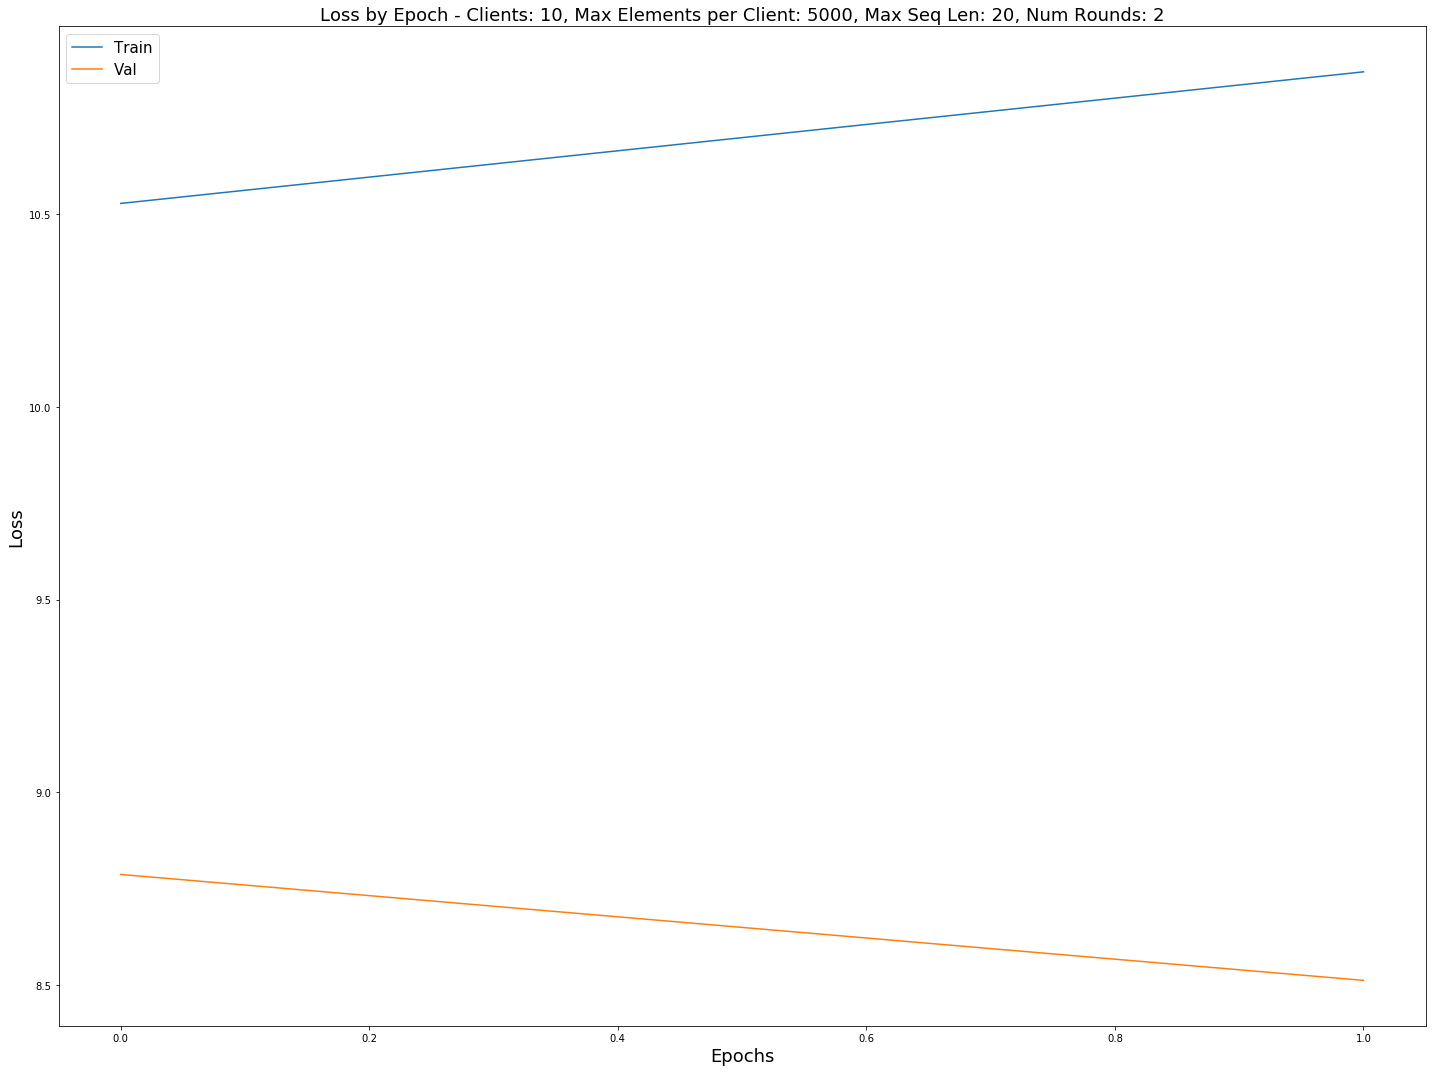

In [71]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Loss by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Loss by Epoch.png')
plt.show()

### Plot Train and Validation Accuracy

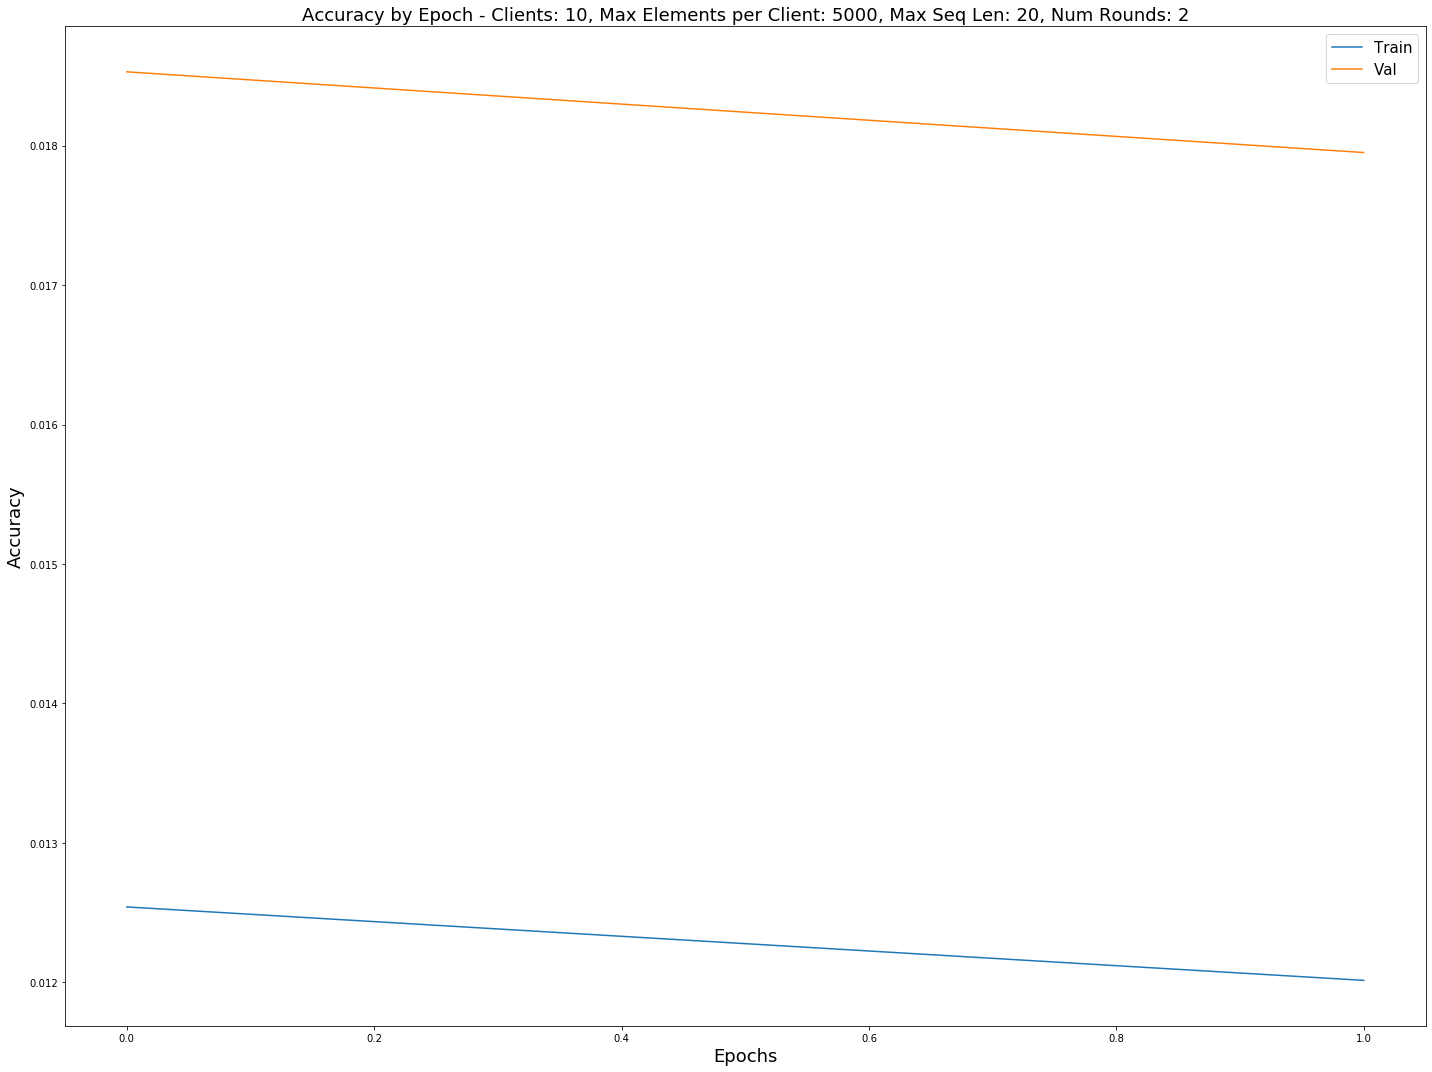

In [72]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
ax.legend(loc='best', prop={'size': 15})
plt.title('Accuracy by Epoch - {}'.format(round_config), fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.tight_layout()
plt.savefig(SAV + 'Accuracy by Epoch.png')
plt.show()